In [1]:
#Get the neccesarry imports from Keras along with other modules to be used later
import tweepy
import numpy as np
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Dropout, concatenate
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import metrics
from keras.models import Model
import pickle
import os
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
#now autheticate with Twitter in order to use API to download tweets
consumer_key = your_consumer_key
consumer_secret = your_consumer_secret
access_token = your_access_token
access_token_secret = your_access_token_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
#Now download all the tweets we want to train on

#Choosing which accounts to download tweets from
sources = ['BarackObama', 'realDonaldTrump']
labels = []
all_tweets = [] #ascii
tweet_count = 0 
label_count = 0 

#For each account in sources download all possible tweets
for s in range(len(sources)):

    tweets = []
    
    #maximum batch size for tweet download is 200 tweets, so must loop through in increments of 200
    new_tweets = api.user_timeline(screen_name = sources[s], count = 200)
    tweets.extend(new_tweets)
    oldest = tweets[-1].id -1
    
    while len(new_tweets) > 0:
        print "getting twets before %s" % (oldest)
        new_tweets = api.user_timeline(screen_name = sources[s], count = 200, max_id = oldest)
        tweets.extend(new_tweets)
        oldest = tweets[-1].id - 1
        print "...%s tweets downloaded so far" % (len(tweets))
        print oldest
    
    for tweet in tweets:
        ascii_text = tweet.text.encode('ascii','ignore')
        all_tweets.append(ascii_text)
        labels.append(s)
        tweet_count += 1
        label_count += 1

getting twets before 776134671415451647
...400 tweets downloaded so far
748928742106488832
getting twets before 748928742106488832
...600 tweets downloaded so far
726435103556141055
getting twets before 726435103556141055
...800 tweets downloaded so far
705137396187340799
getting twets before 705137396187340799
...1000 tweets downloaded so far
687099389483958271
getting twets before 687099389483958271
...1200 tweets downloaded so far
668933428620857346
getting twets before 668933428620857346
...1400 tweets downloaded so far
648539602848886784
getting twets before 648539602848886784
...1600 tweets downloaded so far
628965547690954751
getting twets before 628965547690954751
...1800 tweets downloaded so far
616281266975956991
getting twets before 616281266975956991
...2000 tweets downloaded so far
598921453338136575
getting twets before 598921453338136575
...2200 tweets downloaded so far
581193144181604351
getting twets before 581193144181604351
...2399 tweets downloaded so far
5608477165

In [4]:
#now shuffle the data

shuffle = np.arange(len(all_tweets))
np.random.shuffle(shuffle)

tweets_temp = []
labels_new = []
for index in shuffle:
    tweets_temp.append(all_tweets[index])
    labels_new.append(labels[index])

#create a numpy matrix for the labels
labels_np = np.array(labels_new)

all_tweets = tweets_temp

#take a peak at the shuffle results
for i in range(0,100,10):
    print all_tweets[i]
    print labels_new[i]


Donald E. Ballard, on behalf of the people of the United States, THANK YOU for your courageous service. YOU INSPIRE https://t.co/gyNDamEaC5
1
RT @WhiteHouse: Were giving you some news you can use! @POTUS on the #CollegeScorecard: http://t.co/uSm7RV56Ul http://t.co/op7gPXmztD
0
The President has a plan to fight climate changeyou should support it: http://t.co/AWLXVGm0y8 #ActOnClimate
0
Long-term unemployment is on the decline. Let's keep the economy moving in the right direction: http://t.co/ItcXk2XaDB #ActOnJobs
0
It's time for Senate leaders to put politics aside and fill the Supreme Court vacancy. #DoYourJob https://t.co/UAhLXYqgTN
0
Our country has the slowest growth since 1929. #BigLeagueTruth #debate
1
"I've proposed making two years of community college as free and universal as high school is today." President Obama
0
RT @WhiteHouse: Watch @POTUS speak on the tragic shooting in Roseburg, Oregon. #UCCShooting http://t.co/8sheX2zpFa
0
Weekly Address - 11:00 A.M. at the @WhiteHouse!

In [5]:
#now tokinize the data
tokenizer= Tokenizer()
tokenizer.fit_on_texts(all_tweets)

#save the tokenizer in case we want to use it later in another file
pickle.dump(tokenizer, open('tokenizer','w'))
sequences = tokenizer.texts_to_sequences(all_tweets)
word_index = tokenizer.word_index

print 'Found %s unique tokens.' % len(word_index)

#pad sequences to ensure samples are the same size
training_data = pad_sequences(sequences)

Found 13518 unique tokens.


In [6]:
print "Training data size is (%d,%d)"  % training_data.shape
print "Labels are size %d"  % labels_np.shape

Training data size is (6445,31)
Labels are size 6445


In [7]:
#To make training easier, use the pretrained glove word embeddings
GLOVE_DIR = './glove.6B'
EMBEDDING_DIM = 100
print('Indexing word vectors.')
embeddings_index = pickle.load(open('100_embeddings','r'))
print('Found %s word vectors.' % len(embeddings_index))

# prepare word embedding matrix
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Indexing word vectors.
Found 400000 word vectors.


In [8]:
#now we are going to use Keras function api to build our model

#non-trainable embedding layer used to save time
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=training_data.shape[1],
                            trainable=False)

#define our input to the model
sequence_input = Input(shape = (training_data.shape[1],), dtype='int32')

#word embeddings
embedded_sequences =embedding_layer(sequence_input)

#first part of model is an LSTM
y = Bidirectional(LSTM(200, return_sequences = True))(embedded_sequences)
y = Dropout(.2)(y)
y = Dense(100, activation='relu')(y)
y = Dropout(.2)(y)
y = Dense(1, activation = 'relu')(y)
y = Flatten()(y)

#second part is a CNN
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='relu')(x)
x = Flatten()(x)

#third part is the concatentation of the two prior parts
x = concatenate([x,y])
x = Dense(32, activation='relu')(x)
preds = Dense(1, activation = 'sigmoid')(x)

model = Model(sequence_input, preds)

print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 31)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 31, 100)       1351900                                      
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 31, 400)       481600                                       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 31, 400)       0                                            
___________________________________________________________________________________________

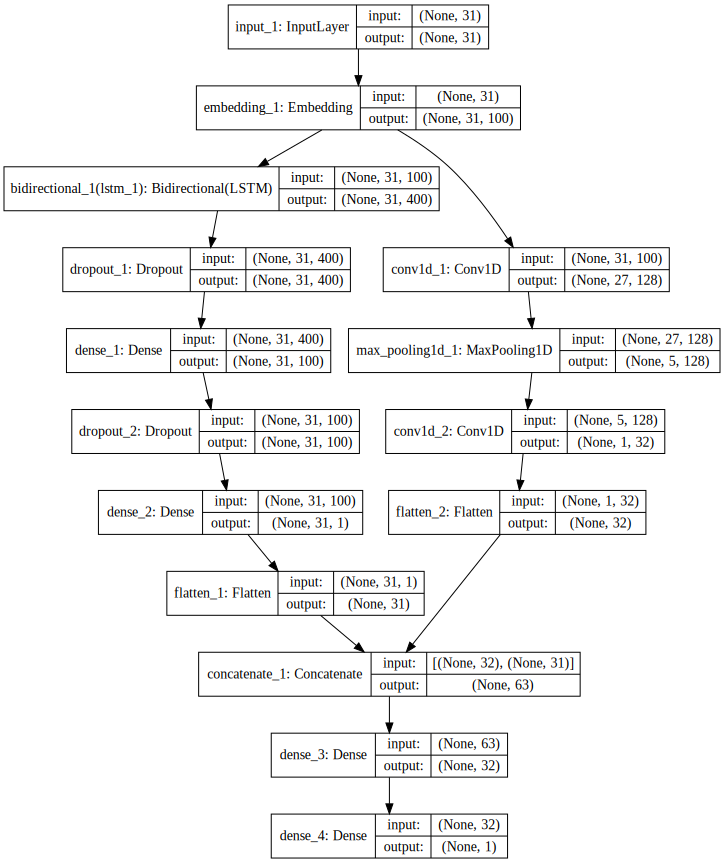

In [9]:
#visual display
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

In [10]:
#compile and train the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metrics.binary_accuracy])

filepath="./weights/testing/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience =0)
tensorboard = TensorBoard()
callbacks_list = [checkpoint, earlystop, tensorboard]

model.fit(training_data[:-500], labels_np[:-500], epochs = 10, batch_size = 128, validation_split =.1, callbacks = callbacks_list)


Train on 5350 samples, validate on 595 samples
Epoch 1/10
5350/5350 [==============================] - 38s - loss: 0.4764 - binary_accuracy: 0.7630 - val_loss: 0.3007 - val_binary_accuracy: 0.8739
Epoch 2/10
5350/5350 [==============================] - 34s - loss: 0.2188 - binary_accuracy: 0.9166 - val_loss: 0.2059 - val_binary_accuracy: 0.9210
Epoch 3/10
5350/5350 [==============================] - 33s - loss: 0.1329 - binary_accuracy: 0.9520 - val_loss: 0.1608 - val_binary_accuracy: 0.9429
Epoch 4/10
5350/5350 [==============================] - 33s - loss: 0.0867 - binary_accuracy: 0.9703 - val_loss: 0.1640 - val_binary_accuracy: 0.9496


In [12]:
#now let's test the model
scores = model.evaluate(training_data[-500:], labels_np[-500:])
print "Test set accuracy is %d" % (scores[1]*100)

500/500 [==============================] - 1s     
Test set accuracy is 94
